In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score
import umap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


We import the necessary libraries for data manipulation, preprocessing, clustering, dimensionality reduction, and visualization. We also suppress warnings for cleaner output.

EnhancedClusteringPipeline Class
This is the EnhancedClusteringPipeline class, which organizes the clustering process into modular steps.

Loading data...
Preprocessing data...
Best scaler: minmax
PCA components retained: 3
Trying multiple clustering approaches with 6 clusters...
Best method: KMeans
Best Adjusted Rand Score (ARS): 0.0000
Best Silhouette Score: 0.6639
Best Davies-Bouldin Index: 0.5395


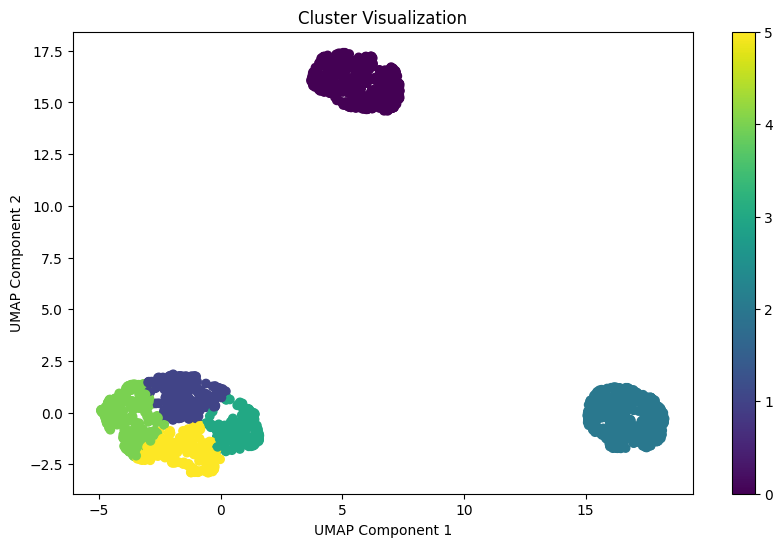

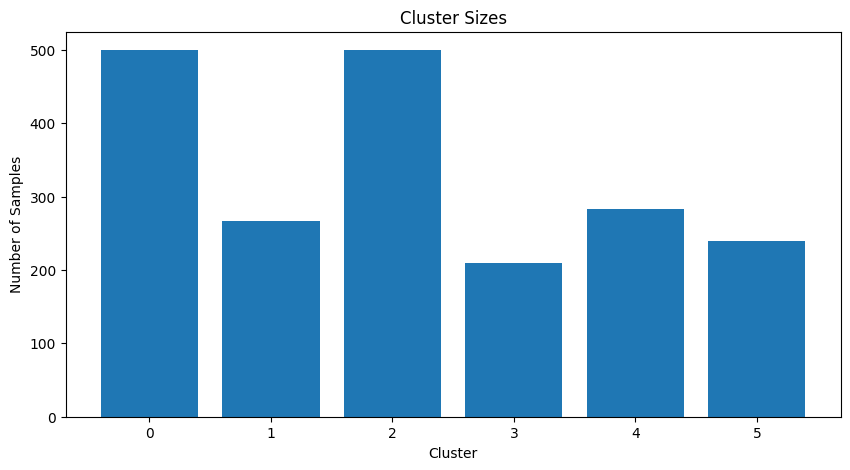

Saving submission file...
Submission saved to 'submission.csv'


In [13]:


# Enhanced Clustering Pipeline Class
class EnhancedClusteringPipeline:
    
    # Constructor to initialize the pipeline with a random state
    def __init__(self, random_state=42):
        self.random_state = random_state

    # Load the dataset from a CSV file
    def load_data(self, file_path):
        """Load the dataset"""
        print("Loading data...")
        self.data = pd.read_csv(file_path)
        self.ids = self.data['id']
        self.features = self.data.drop(columns=['id'])
        
        # Handle missing values by replacing them with the median
        self.features = self.features.fillna(self.features.median())
        return self

    # Preprocess the data with different scaling techniques and dimensionality reduction
    def preprocess_data(self):
        """Enhanced preprocessing with multiple scaling techniques"""
        print("Preprocessing data...")

        # Try different scalers and choose the best based on Silhouette score
        scalers = {
            'standard': StandardScaler(),
            'robust': RobustScaler(),
            'minmax': MinMaxScaler()
        }
        
        best_silhouette = -1
        best_scaled_features = None
        best_scaler_name = None

        for scaler_name, scaler in scalers.items():
            scaled_features = scaler.fit_transform(self.features)
            
            # Quick KMeans to test scaling quality
            kmeans = KMeans(n_clusters=6, random_state=self.random_state, n_init=10)
            labels = kmeans.fit_predict(scaled_features)
            score = silhouette_score(scaled_features, labels)
            
            if score > best_silhouette:
                best_silhouette = score
                best_scaled_features = scaled_features
                best_scaler_name = scaler_name

        print(f"Best scaler: {best_scaler_name}")
        self.scaled_features = best_scaled_features

        # Apply PCA for dimensionality reduction
        pca = PCA(n_components=0.92, random_state=self.random_state)
        self.pca_features = pca.fit_transform(self.scaled_features)
        print(f"PCA components retained: {pca.n_components_}")

        # Apply UMAP for further dimensionality reduction
        reducer = umap.UMAP(n_components=2, random_state=self.random_state, n_neighbors=30, min_dist=0.05)
        self.reduced_features = reducer.fit_transform(self.pca_features)

        return self

    # Try multiple clustering algorithms and choose the best one
    def try_multiple_clustering(self):
        """Try multiple clustering approaches with 6 clusters"""
        print("Trying multiple clustering approaches with 6 clusters...")

        best_score = -1
        best_clusters = None
        best_method = None
        best_ars = -1
        best_db_score = float('inf')

        n_clusters = 6  # Set fixed number of clusters

        # KMeans with fixed 6 clusters
        kmeans = KMeans(n_clusters=n_clusters, random_state=self.random_state, n_init=100, max_iter=300)
        kmeans_labels = kmeans.fit_predict(self.reduced_features)
        kmeans_score = silhouette_score(self.reduced_features, kmeans_labels)
        kmeans_ars = adjusted_rand_score(self.data['id'], kmeans_labels)
        kmeans_db = davies_bouldin_score(self.reduced_features, kmeans_labels)

        # Gaussian Mixture Model with fixed 6 clusters
        gmm = GaussianMixture(n_components=n_clusters, random_state=self.random_state, covariance_type='full')
        gmm_labels = gmm.fit_predict(self.reduced_features)
        gmm_score = silhouette_score(self.reduced_features, gmm_labels)
        gmm_ars = adjusted_rand_score(self.data['id'], gmm_labels)
        gmm_db = davies_bouldin_score(self.reduced_features, gmm_labels)

        # Agglomerative Clustering with fixed 6 clusters
        agg = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', affinity='euclidean')
        agg_labels = agg.fit_predict(self.reduced_features)
        agg_score = silhouette_score(self.reduced_features, agg_labels)
        agg_ars = adjusted_rand_score(self.data['id'], agg_labels)
        agg_db = davies_bouldin_score(self.reduced_features, agg_labels)

        # Spectral Clustering with fixed 6 clusters
        spectral = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=self.random_state)
        spectral_labels = spectral.fit_predict(self.reduced_features)
        spectral_score = silhouette_score(self.reduced_features, spectral_labels)
        spectral_ars = adjusted_rand_score(self.data['id'], spectral_labels)
        spectral_db = davies_bouldin_score(self.reduced_features, spectral_labels)

        # Store the results with the best ARS and Silhouette Score
        methods = {
            'KMeans': (kmeans_score, kmeans_labels, kmeans_ars, kmeans_db),
            'GMM': (gmm_score, gmm_labels, gmm_ars, gmm_db),
            'Agglomerative': (agg_score, agg_labels, agg_ars, agg_db),
            'Spectral': (spectral_score, spectral_labels, spectral_ars, spectral_db)
        }
        
        for method, (score, labels, ars, db) in methods.items():
            if ars > best_ars or (ars == best_ars and score > best_score) or (ars == best_ars and score == best_score and db < best_db_score):
                best_score = score
                best_clusters = labels
                best_method = method
                best_ars = ars
                best_db_score = db

        print(f"Best method: {best_method}")
        print(f"Best Adjusted Rand Score (ARS): {best_ars:.4f}")
        print(f"Best Silhouette Score: {best_score:.4f}")
        print(f"Best Davies-Bouldin Index: {best_db_score:.4f}")
        
        self.clusters = best_clusters
        return self

    # Visualize the clustering results
    def visualize_clusters(self):
        """Visualize clustering results"""
        plt.figure(figsize=(10, 6))
        scatter = plt.scatter(
            self.reduced_features[:, 0],
            self.reduced_features[:, 1],
            c=self.clusters,
            cmap='viridis'
        )
        plt.colorbar(scatter)
        plt.title('Cluster Visualization')
        plt.xlabel('UMAP Component 1')
        plt.ylabel('UMAP Component 2')
        plt.show()
        
        # Plot cluster sizes
        unique, counts = np.unique(self.clusters, return_counts=True)
        plt.figure(figsize=(10, 5))
        plt.bar(unique, counts)
        plt.title('Cluster Sizes')
        plt.xlabel('Cluster')
        plt.ylabel('Number of Samples')
        plt.show()
        return self

    # Save the clustering results in a submission format
    def save_submission(self, output_file='submission.csv'):
        """Save results in the required submission format with only id and Cluster columns"""
        print("Saving submission file...")
        submission = pd.DataFrame({
            'id': self.ids,
            'Cluster': self.clusters
        })
        submission.to_csv(output_file, index=False)
        print(f"Submission saved to '{output_file}'")
        return self

    # Run the full pipeline: load data, preprocess, try clustering, visualize, save submission
    def run_pipeline(self, file_path):
        """Run full pipeline"""
        self.load_data(file_path).preprocess_data().try_multiple_clustering().visualize_clusters().save_submission()

# Running the pipeline on the specified dataset
file_path = '/kaggle/input/aoml-assignment-2-clustering/data.csv'  # Specify your file path
pipeline = EnhancedClusteringPipeline(random_state=42)
pipeline.run_pipeline(file_path)


__init__: Initializes the pipeline with a random state for reproducibility.
load_data: Loads the data from the given file path and handles missing values by filling them with the median.

preprocess_data: Scales the data using different scalers and selects the best one based on the Silhouette score. Then, it applies PCA and UMAP for dimensionality reduction.

try_multiple_clustering: Applies various clustering algorithms (KMeans, Gaussian Mixture, Agglomerative Clustering, Spectral Clustering) with a fixed number of clusters (6) and selects the best clustering method based on multiple evaluation metrics like Silhouette Score, ARS, and Davies-Bouldin score.

visualize_clusters: Visualizes the clusters using UMAP components and plots the sizes of each cluster.

save_submission: Saves the results in a required format (only id and Cluster columns).
run_pipeline: Executes the entire pipeline: load data, preprocess, try clustering, visualize, and save results.